In [1]:
import numpy as np
import pandas as pd
import string
import re
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [16,12]

# from sklearn import manifold
from itertools import product, combinations
from nltk.corpus import stopwords
# from scipy.stats import rankdata


## to-dos

### 1. create a "make plot" function
### 2. Better model
* include words similar to vocab
* penalty to stopwords
* other models: phonec spelling

### 4. Frontend
* A "how it works" page
* "bring me to" the link

### 5. more content:
* more genre
* another app (another website)




In [2]:
# read
books = pd.read_csv('fiction.csv')

In [79]:
# from gensim.models import KeyedVectors, Phrases
# filename = '/Users/weitinglin/Documents/GoogleNews-vectors-negative300.bin'
# model = KeyedVectors.load_word2vec_format(filename, binary=True)


## Build a smaller model
#### 1. get a list of common words

In [80]:

file = "/Users/weitinglin/Documents/google-20000-english-usa.txt"
with open(file, 'r') as f:
    x = f.readlines()

common = [w.strip() for w in x if w.strip() != ""]

### Make my own dictionary

In [ ]:
fiction = pd.read_csv('fiction_500.csv')

In [ ]:
def make_dictionary(books):
    temp = []
    for b in books:
        temp = temp + re.split('[\W\s]+', b.lower()) 
    return set(temp)

In [97]:
dict1 = list(make_dictionary(fiction['title']))

### get union of 20k common words and  vocabs in from the 500 books

In [100]:
more_common = set(common + dict1)

In [101]:
### make a dictionary
common_dict = {}
for w in more_common:
    if w in model.vocab:
        common_dict[w] = model.get_vector(w)

In [102]:
import dill
dill.dump(common_dict, open("morecommon_dict.pkl","wb"))

In [ ]:
# all the above only have to do once

In [38]:
# c_dict = dill.load( open("common_dict.pkl","rb"))

## mock up the web app

In [36]:
import numpy as np
import pandas as pd
import string
import re
import dill
# import matplotlib.pyplot as plt
# %matplotlib inline
# plt.rcParams["figure.figsize"] = [16,12]

# from sklearn import manifold
from itertools import product, combinations
from nltk.corpus import stopwords
from scipy.stats import rankdata

In [37]:
c_dict = dill.load( open("morecommon_dict.pkl","rb"))# 20k + my_dict
# c_dict = dill.load( open("common_dict.pkl","rb"))
vocab = c_dict.keys()
books = pd.read_csv('fiction.csv')

In [38]:
len(vocab)

18883

### the string trimming function

In [39]:
def trim_string(S):
    '''
    trim useless words if string is too long
    '''
    mystr1 = re.split('[\W\s]+', S)
    # split at punctuation or space
    
    mystr =[s.lower() for s in mystr1] 
    # Remove "the", "a", "an"
    nonsense = ["the", "a", "an", "and", "to","on", "from", "in", "by"]
    mystr = [word for word in mystr if word.lower() not in nonsense]
        
    # remove more
    mystr_less = [word for word in mystr if word.lower() not in stopwords.words('english')]
    
    if len(mystr_less) > 0 :
        mystr = mystr_less
    
    # remove placeholder 
    mystr_less = [s for s in mystr if s in vocab]
    if len(mystr_less) > 0 :
        mystr = mystr_less
        
    return mystr

In [40]:
temp = trim_string('Slaughterhouse-Five')
temp

['slaughterhouse', 'five']

In [5]:
trim_string('dragonfly in amber')

['dragonfly', 'amber']

In [6]:
len(vocab)

18883

In [7]:
c_dict['banana'].shape

(300,)

In [41]:
def str2mat(instr, limit = 5, placeholder = None):
    '''
    Convert string to a vector base on average vector of the composing words.
    instr: the inpput string
    placeholder: for the non-vocabularies
    '''
    # make a place-holder: mean of three strange words
    if placeholder is None:
        ph = np.ones(300)* 3
    
    mystr = trim_string(instr)
    
    # number of words
    L = min(len(mystr), limit) 
    
    ## padding up
    sheet = np.ones((300, limit))* 2 
    for l in range(L):
        if (mystr[l] in vocab):
            sheet[:,l] = c_dict[mystr[l]]
        else:
            sheet[:,l] = ph
  
    return L, sheet

In [9]:
str2mat('dragonfly in amber')

(2, array([[ 3.44238281e-02,  1.77764893e-03,  2.00000000e+00,
          2.00000000e+00,  2.00000000e+00],
        [ 8.98437500e-02, -3.51562500e-02,  2.00000000e+00,
          2.00000000e+00,  2.00000000e+00],
        [-2.83203125e-01,  1.12304688e-01,  2.00000000e+00,
          2.00000000e+00,  2.00000000e+00],
        ...,
        [-5.51757812e-02,  1.16699219e-01,  2.00000000e+00,
          2.00000000e+00,  2.00000000e+00],
        [-4.98046875e-02,  2.08007812e-01,  2.00000000e+00,
          2.00000000e+00,  2.00000000e+00],
        [-2.45666504e-03, -1.25000000e-01,  2.00000000e+00,
          2.00000000e+00,  2.00000000e+00]]))

In [42]:
def compare_mats(M1, M2 , ph = 2, stress = 0.2, penalty = 0.5):
    n, limit = M1.shape
    L1 = sum(M1[0,:] != 2 ) # lenth of 
    L2 = sum(M2[0,:] != 2 ) 
    # trim 
    M1_trim = M1[:, 0:L1]
    M2_trim = M2[:, 0:L2]
    
    if L1 == 1:
        lin_dist = M2_trim - M1_trim
        euc_dist = [np.sqrt(sum(lin_dist[:,i]  ** 2)) for i in range(L2)]
        dist = min(euc_dist)
    elif L2 == 1:
        lin_dist = np.tile(M2_trim, L1) - M1_trim
        euc_dist = [np.sqrt(sum(lin_dist[:,i]  ** 2)) for i in range(L1)]
        # use mean if target is more than 1 words
        dist = np.mean(euc_dist) 
    else:
        # 
        ind_product = list(product(np.arange(L2), repeat=L1)) # select from M2 to match the size of M1
        ind_combination = list(combinations(np.arange(L2), L1)) 
        eucs = []
        for p, ind in enumerate(ind_product): # 2, (0,1):
            M2_p = M2_trim[:,list(ind)] # permuted M2'
            lin_dist = M2_p - M1_trim
            euc = [np.sqrt(sum(lin_dist[:,i]  ** 2)) for i in range(L1)]
            mean_euc = np.mean(euc)
            if ind not in ind_combination:
                mean_euc = mean_euc * (stress + 1)
            eucs.append(mean_euc)
        dist = min(eucs)
    # penalty for unequal list
    if L2 > L1:
        dist = dist +  ((L2 - L1)/(L1 + L2) * penalty)
    return dist

In [43]:
def compare_strs(S1, S2, limit = 5, placeholder = None):
    _, M1 = str2mat(S1, limit = limit)
    _, M2 = str2mat(S2, limit = limit)
    return compare_mats(M1, M2 , ph = placeholder)

In [44]:
def fuzzy_find2(mytitle, shelf, maxshow = 10, threshhold = 5):
    '''
    mytitle: the user input keyword for fuzzy search
    shelf: df with column named 'title', find book from
    maxshow: the max. number of result return.
    threshhold: threshhold of similarity for the "match"
    '''
    dist = []
    for s in shelf["title"]:
        dist.append(compare_strs(mytitle, s))
    dist = np.array(dist)
    
    fuzzy = np.where(dist < threshhold)[0]
    L = len(fuzzy)
    if L > maxshow:
        rankF = rankdata(dist, method='min') 
        fuzzy = np.where(rankF <= maxshow)[0]

#     return shelf["title"][fuzzy], dist[fuzzy]
    return list(shelf["title"][fuzzy]), fuzzy

In [28]:
b, _ = fuzzy_find2('Butterfly in resin', books, maxshow=5)

### making the vis

In [45]:
from sklearn import manifold
from numpy.random import random

In [46]:
def string_distance(Slist, limit = 5, placeholder = None):
    '''
    Return a distance matrix for strings in Slist
    '''
    N = len(Slist)
    dist = np.zeros((N,N))
    for i in range(N):
        for j in range(i,N):
            dist[i,j] = compare_strs(Slist[i], Slist[j], limit=limit, placeholder=placeholder)
            dist[j,i] = dist[i,j]
    return dist
    
    

In [23]:
Strings = ['Butterfly in resin', 'Dragonfly in amber', 'dark tower'] 
res = string_distance(Strings)
res

array([[0.        , 3.57965192, 4.3279994 ],
       [3.57965192, 0.        , 4.13174269],
       [4.3279994 , 4.13174269, 0.        ]])

In [28]:
Y = manifold.MDS(n_components= 2,n_init = 100,random_state=1,dissimilarity='precomputed').fit_transform(res)

In [29]:
Y

array([[-2.22271276, -0.44069352],
       [ 1.07828975, -1.84136861],
       [ 1.14442301,  2.28206213]])

In [59]:
suggest_books, _ = fuzzy_find2('Butterfly in resin', books, maxshow=20)

In [61]:
suggest_books + ['Butterfly in resin']

['The Great Alone',
 'The Alice Network',
 'See Me',
 'It',
 'Call Me by Your Name',
 'Cutting for Stone',
 'The Brief Wondrous Life of Oscar Wao',
 'Lincoln in the Bardo',
 'The Tuscan Child',
 'The Stand',
 'Big Little Lies',
 'History Is All You Left Me',
 'Still Me',
 'All the Light We Cannot See',
 'Dragonfly in Amber ',
 'At Home in Mitford',
 'The Edgar Allan Poe Audio Collection',
 'We Are Water',
 'Never Too Late',
 'Little Big Man',
 'Butterfly in resin']

In [31]:
Y = manifold.MDS(n_components= 2,n_init = 100,random_state=1,dissimilarity='precomputed')\
    .fit_transform(string_distance(suggest_books))

In [69]:
# suggestion_map function 
# returns (Y, notation)
def suggestion_map(mytitle, shelf, n_init =10, maxshow=20):
    # 1. get a list of suggested books
    S_list, S_indices = fuzzy_find2(mytitle, shelf, maxshow = maxshow, threshhold = 5)
    # 2. calculate distance matrix
    Dist = string_distance(S_list + [mytitle], limit = 5, placeholder = None)
    # 3. calculate Y
    Y = manifold.MDS(n_components= 2, n_init =  n_init, dissimilarity='precomputed')\
                     .fit_transform(Dist)
    # 4. get notation
    notation = S_list + [mytitle]
    
    return Y, notation
    

In [70]:
%%timeit
Y, notes = suggestion_map('Butterfly in resin', books)

3.99 s ± 157 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [71]:
%%timeit
Y, notes = suggestion_map('Butterfly in resin', books,  n_init =5)

3.59 s ± 94.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [72]:
%%timeit
Y, notes = suggestion_map('Butterfly in resin', books,  maxshow=15)

3.42 s ± 59.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [85]:
 Dist = string_distance(suggest_books + ['Butterfly in resin'], limit = 5, placeholder = None)

In [88]:
5-Dist[-1,:]

array([4.01566629, 3.97956625, 3.92991709, 3.76501096, 4.01599256,
       3.9704159 , 4.87986749, 3.96628173, 3.89441929, 4.11721266,
       4.7780014 , 3.85943067, 3.91511528, 4.71436266, 3.57965192,
       4.09137263, 4.715213  , 3.86505552, 3.89154253, 4.63619848,
       0.        ])

In [89]:

import matplotlib.pyplot as plt
sizes = np.ones(len(Y))
sizes[-1] = sizes[-1] * 2
plt.scatter(Y[:,0], Y[:,1], s = 5-Dist[-1,:], c="g", alpha=0.5, marker=r'$\clubsuit$',
            label="Luck")

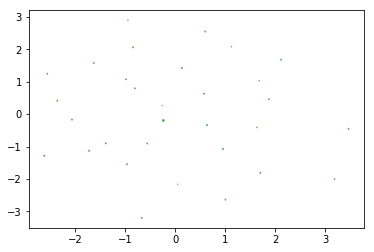

In [90]:
plt.show()

In [74]:
sizes = np.ones(20) * 0.01
sizes[-1] = sizes[-1] * 2

In [75]:
sizes


array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02])

In [92]:
colar = ["#1f1b99" for i in sizes]
colar[-1] = "#f442c5"

In [93]:
max(Y[:,0]) + 1

3.463936909774312

In [102]:
Yin = Y
xmock = max(Yin[:,0]) + 1
ymock = max(Yin[:,1]) + 1
Y2 = np.concatenate((np.array([xmock, ymock]).reshape(1,2),  Yin), axis=0) 
 


In [103]:
Y2.shape

(32, 2)

In [104]:
Yin.shape

(31, 2)

In [106]:
np.concatenate((np.array([""]),  suggest_books), axis=0)

array(['', 'The Great Alone', 'The Alice Network', 'See Me', 'It',
       'Call Me by Your Name', 'Cutting for Stone',
       'The Brief Wondrous Life of Oscar Wao', 'Lincoln in the Bardo',
       'The Tuscan Child', 'The Stand', 'Big Little Lies',
       'History Is All You Left Me', 'Still Me',
       'All the Light We Cannot See', 'Dragonfly in Amber ',
       'At Home in Mitford', 'The Edgar Allan Poe Audio Collection',
       'We Are Water', 'Never Too Late', 'Little Big Man'], dtype='<U36')